In [1]:
# The pre-processing process is exactly the same as that in PAC, so direclty skip the redundant codes.
include("utils.jl")
Random.seed!(1234)

# Generate random input data.
class_num = 3
sample_per_class = 30
data = genData(sample_per_class, [-1.5, 0., 2.], [0.25, 1., 1.3])

# Preprocess: center the raw input data.
c, global_mean = centered(data);

In [2]:
# Scatter matrix of between-class measurement.
Sb = zeros(class_num, class_num)
# Scatter matrix of within-class measurement.
Sw = zeros(class_num, class_num)

start = 1
scale = 1 / sample_per_class

function cov(a) # convariance matrix for a row vector
    a = size(a, 1) > 1 ? a' : a 
    c = (a' * a)
    c .* (1 / size(c, 1) - 1)
end

for pos in sample_per_class : sample_per_class : sample_per_class * class_num
    class_mean = mean(view(data[start : pos, :], :, :), dims=1)
    Sb += cov(class_mean .- global_mean)
    
    sliced = view(data[start : pos, :], :, :)
    for i in 1 : sample_per_class
        Sw += (cov(sliced[i, :] .- class_mean) .* scale)
    end
    start = pos + 1
end
Sw ./= class_num

using LinearAlgebra
@show rank(Sb)
@show rank(Sw);

rank(Sb) = 2
rank(Sw) = 3


In [3]:
F = eigen(inv(Sw) * Sb)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
3-element Array{Float64,1}:
  5.925147173115148     
 -2.1018252808658712e-16
  0.008980709076687085  
eigenvectors:
3×3 Array{Float64,2}:
 -0.634885  -0.526642   0.56669 
 -0.360159  -0.226509  -0.808167
 -0.683525   0.819355   0.160404

In [4]:
# Project to a low-dimensional space.
sorted_idx = sort(hcat(F.values, 1 : length(F.values)), dims=1, by=x -> x[1], rev=true)[:,2]
# project to 2D
w2 = [F.vectors[Int(sorted_idx[1]), :]'; F.vectors[Int(sorted_idx[2]), :]']

proj_2d = zeros(sample_per_class * class_num, 2)
start = 1
for pos in sample_per_class : sample_per_class : sample_per_class * class_num
    proj_2d[start : pos, :] = view(data[start:pos, :], :, :) * w2'
    start = pos + 1
end

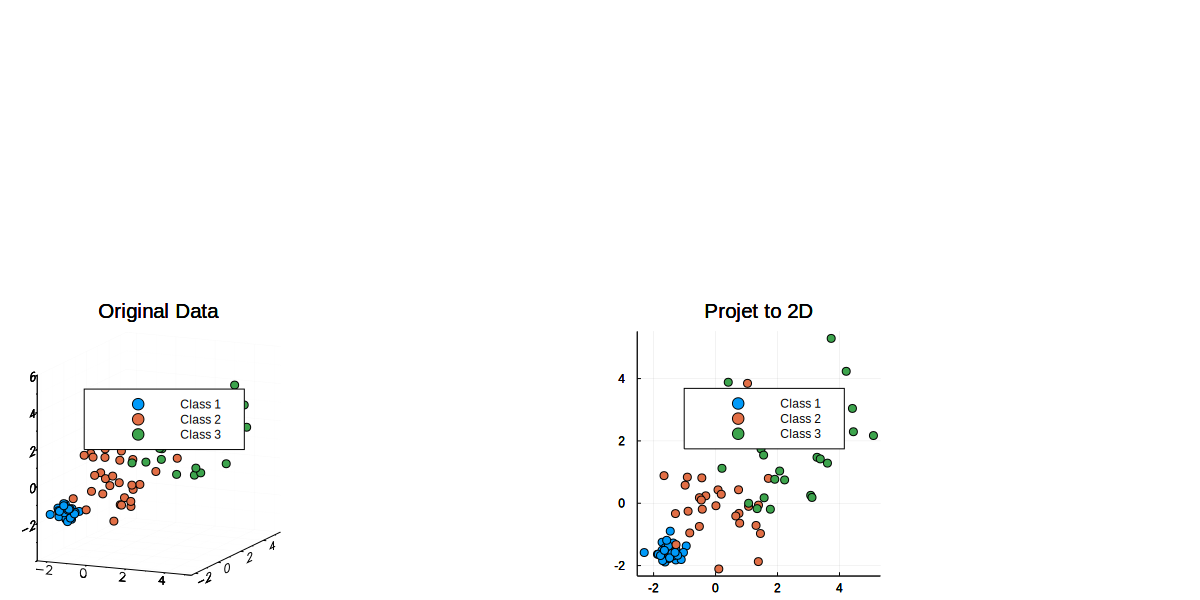

In [5]:
# Plot
function plotScatter(in_data, sample_per_class, title;dim=3, legend=:bottomleft)
    c1 = view(data[1 : sample_per_class, :], :, :)
    c2 = view(data[sample_per_class + 1 : sample_per_class * 2, :], :, :)
    c3 = view(data[sample_per_class * 2 + 1 : sample_per_class * 3, :], :, :)

    if dim == 3
        s1 = scatter(c1[:, 1], c1[:, 2], c1[:, 3], label="Class 1")
        s2 = scatter!(c2[:, 1], c2[:, 2], c2[:, 3], label="Class 2")
        s3 = scatter!(c3[:, 1], c3[:, 2], c3[:, 3], label="Class 3", title=title)
    elseif dim == 2
        s1 = scatter(c1[:, 1], c1[:, 2], label="Class 1")
        s2 = scatter!(c2[:, 1], c2[:, 2], label="Class 2")
        s3 = scatter!(c3[:, 1], c3[:, 2], label="Class 3", title=title)
    else error("Not supported") end
    return plot(s1, s2, s3)
end


orig = plotScatter(data, sample_per_class, "Original Data")
proj = plotScatter(proj_2d, sample_per_class, "Projet to 2D"; dim=2)
plot(orig, proj, layout=(1, 2), size=(600 * 2, 600))